In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from functools import  partial
sys.path.insert(0, '/cluster/work/climate/dnikolo/n2o')
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
config = read_config(
    '/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/configs/config_testing_2024.yaml')

def get_combined_cloud_df(config):
    t_deltas = config['t_deltas']
    agg_fact = config['agg_fact']
    min_temp_array, max_temp_array = config['min_temp_arr'], config['max_temp_arr']
    folder_name = f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"
    # Initialize an empty list to store the individual dataframes
    cloud_properties_df_list = []

    # Iterate over each temperature range
    for i in range(len(min_temp_array)):
        cloud_properties_df_list.append([])
        min_temp = min_temp_array[i]
        max_temp = max_temp_array[i]

        # Iterate over each pole
        for pole in config["pole_folders"]:
            # Construct the file path
            fp = os.path.join(
                config['postprocessing_output_dir'],
                pole,
                folder_name,
                f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
            )

            # Read the parquet file into a dataframe
            try:
                df = pd.read_parquet(fp)
            except:
                continue

            # Add columns for min_temp, max_temp, and pole
            df['min_temp'] = min_temp
            df['max_temp'] = max_temp
            df['pole'] = pole
            df['Hemisphere'] = "South" if pole == "sp" else "North"
            df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
            df["Radius [km]"]=np.sqrt(df["avg_size[km]"]/np.pi)
            # Append the dataframe to the sublist
            cloud_properties_df_list[i].append(df)

    # Combine all dataframes into a single dataframe
    return pd.concat(
        [df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [3]:
combined_cloud_df = get_combined_cloud_df(config)

In [4]:
combined_cloud_df.keys()

Index(['is_large_pix_cloud', 'is_cot_valid_cloud', 'is_ctp_valid_cloud',
       'is_liq', 'is_mix', 'is_ice', 'max_water_frac', 'max_ice_fraction',
       'avg_size[km]', 'max_size[km]', 'min_size[km]', 'avg_size[px]',
       'max_size[px]', 'min_size[px]', 'track_start_time', 'track_length',
       'avg_cot', 'avg_ctp', 'glaciation_start_time', 'glaciation_end_time',
       'avg_lat', 'avg_lon', 'start_ice_fraction', 'end_ice_fraction',
       'ice_frac_hist', 'cot_hist', 'cot_nan_frac_hist', 'ctp_hist',
       'ctp_nan_frac_hist', 'lat_hist', 'lon_hist', 'size_hist_km', 'min_temp',
       'max_temp', 'pole', 'Hemisphere', 'Lifetime [h]', 'Radius [km]'],
      dtype='object')

<Axes: xlabel='avg_ctp', ylabel='Count'>

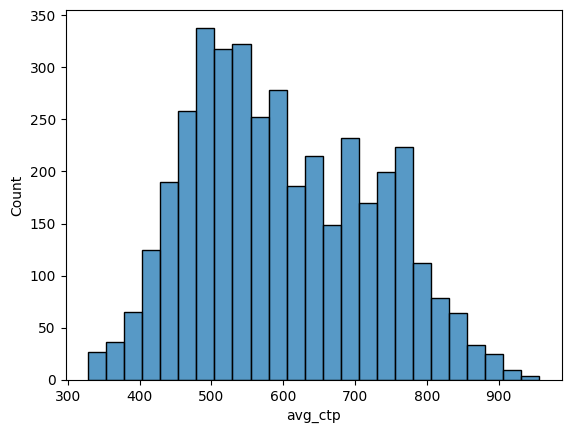

In [5]:
sns.histplot(combined_cloud_df.avg_ctp)

<Axes: xlabel='avg_cot', ylabel='Count'>

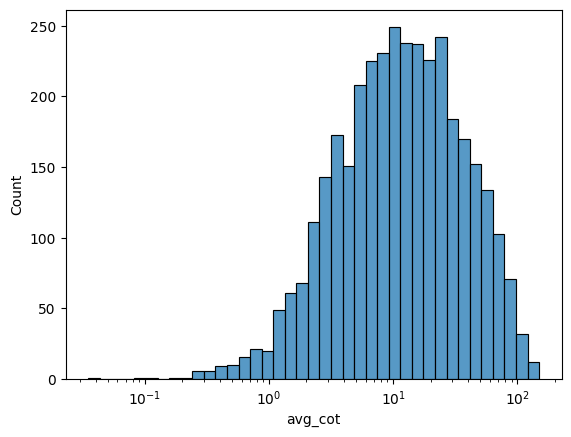

In [6]:
sns.histplot(combined_cloud_df.avg_cot, log_scale=(True,False))

In [7]:
combined_cloud_df.cot_hist.dropna()

0       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
1                     [nan, nan, nan, nan, nan, nan, nan]
2       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
4       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
                              ...                        
8887                       [nan, nan, nan, nan, nan, nan]
8888                                 [nan, nan, nan, nan]
8889                                 [nan, nan, nan, nan]
8890                                 [nan, nan, nan, nan]
8891                               [nan, nan, nan, 150.0]
Name: cot_hist, Length: 8892, dtype: object

In [8]:
combined_cloud_df["Level"] = pd.cut(
    combined_cloud_df.avg_ctp,
    bins=[50, 440, 680, 1000],
    labels=["Cirro","Alto","Low"]
)
combined_cloud_df["Optical Thickness"] = pd.cut(
    combined_cloud_df.avg_cot,
    bins=[0, 3.6, 23, 379],
    labels=["Thin", "Medium", "Thick"]
)

combined_cloud_df["Cloud type"] = list(zip(combined_cloud_df["Level"],combined_cloud_df["Optical Thickness"]))
# Define mapping dictionary
cloud_type_mapping = {
    ("Low", "Thin"): "Cumulus",
    ("Alto", "Thin"): "Altocumulus",
    ("Cirro", "Thin"): "Cirrus",
    ("Low", "Medium"): "Stratocumulus",
    ("Alto", "Medium"): "Altostratus",
    ("Cirro", "Medium"): "Cirrostratus",
    ("Low", "Thick"): "Stratus",
    ("Alto", "Thick"): "Nimbostratus",
    ("Cirro", "Thick"): "Deep convection",
}

# Apply mapping
combined_cloud_df["Cloud type"] = combined_cloud_df["Cloud type"].map(cloud_type_mapping)

# Display the result
print(len(combined_cloud_df["Cloud type"].dropna())/len(combined_cloud_df))


0.14496176338281602


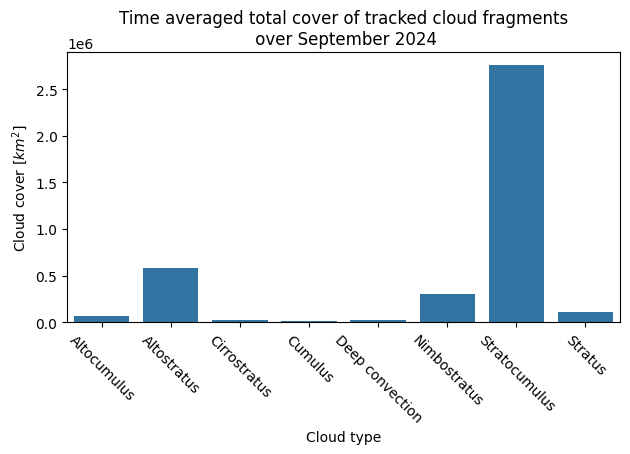

In [14]:
combined_cloud_df["day_frac_cover"] = (combined_cloud_df["avg_size[km]"] * combined_cloud_df["track_length"])/(config["end_time"]-config["start_time"])
nice_clouds = combined_cloud_df[combined_cloud_df.is_large_pix_cloud==False]
type_groups = combined_cloud_df.groupby("Cloud type")
sns.barplot((type_groups["day_frac_cover"].sum()))
# Rotate x-axis labels
plt.xticks(rotation=-45)
plt.title("Time averaged total cover of tracked cloud fragments\n over September 2024")
plt.ylabel("Cloud cover [$km^2$]")
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Cloud_cover_by_type.png",dpi=400)

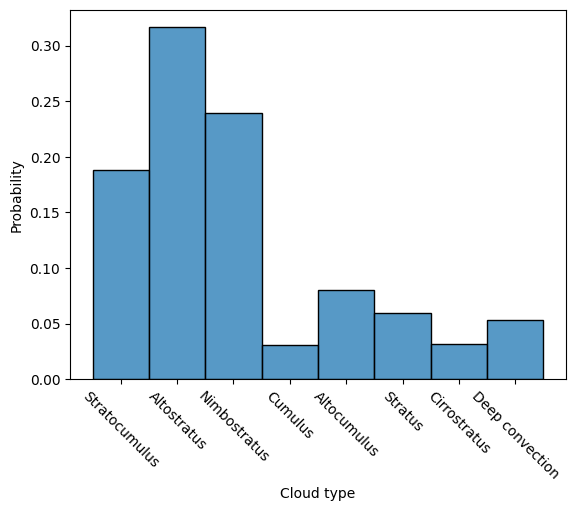

In [10]:
sns.histplot(combined_cloud_df["Cloud type"], stat="probability")

# Rotate x-axis labels
plt.xticks(rotation=-45)

# Show the plot
plt.show()